C:\Users\ajust\anaconda3\envs\tf310\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\ajust\anaconda3\envs\tf310\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ajust\anaconda3\envs\tf310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.8312 - loss: 0.3777


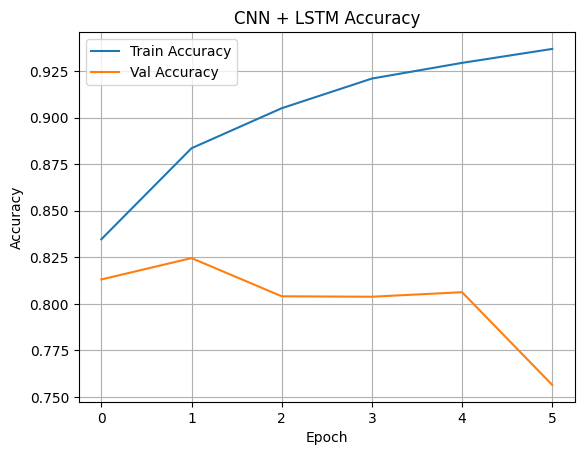

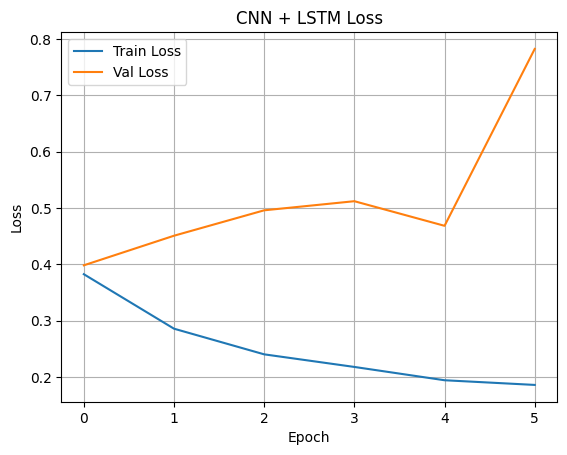

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step 


<Figure size 1000x800 with 0 Axes>

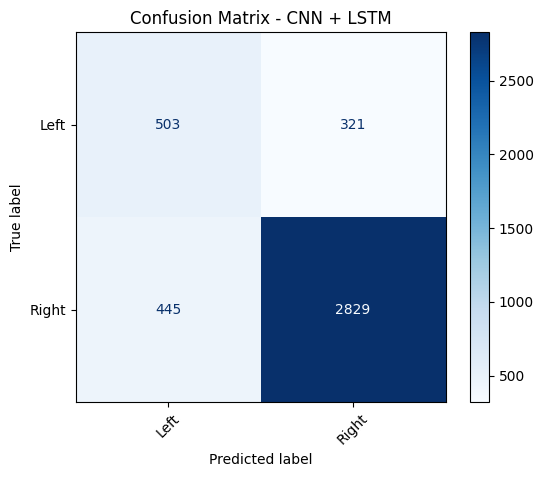

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.8530 - loss: 0.5146 


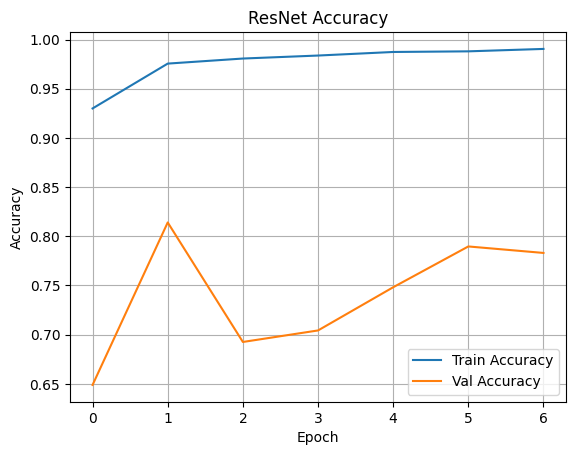

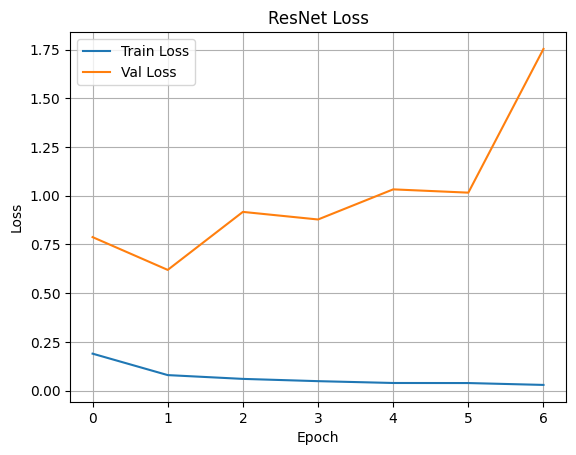

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step


<Figure size 1000x800 with 0 Axes>

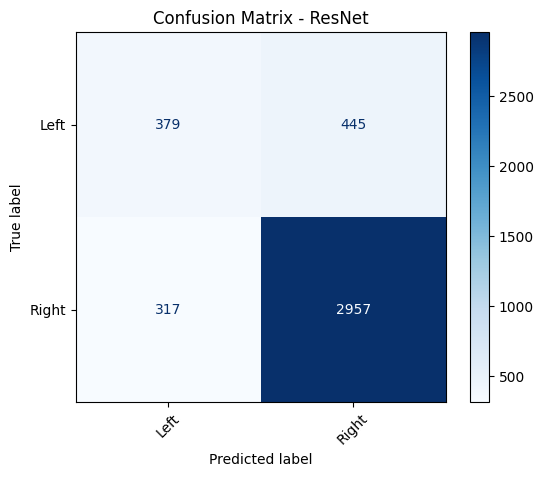

129/129 ━━━━━━━━━━━━━━━━━━━━ 29s 229ms/step - accuracy: 0.8710 - loss: 0.2947


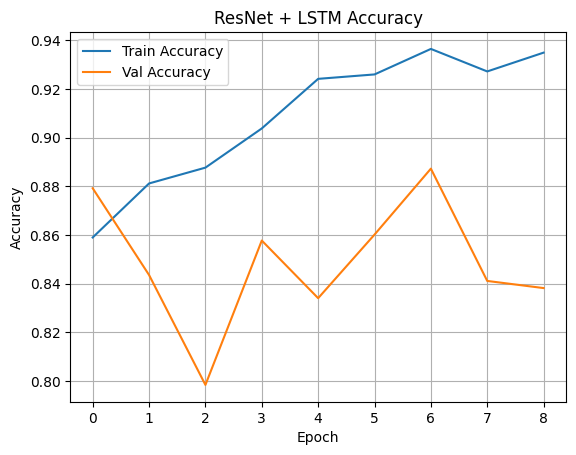

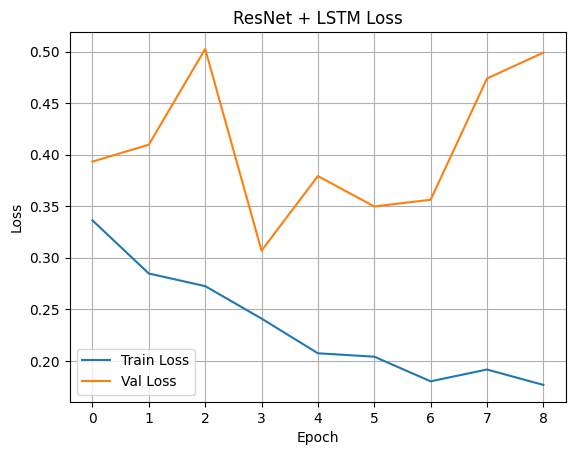

129/129 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step


<Figure size 1000x800 with 0 Axes>

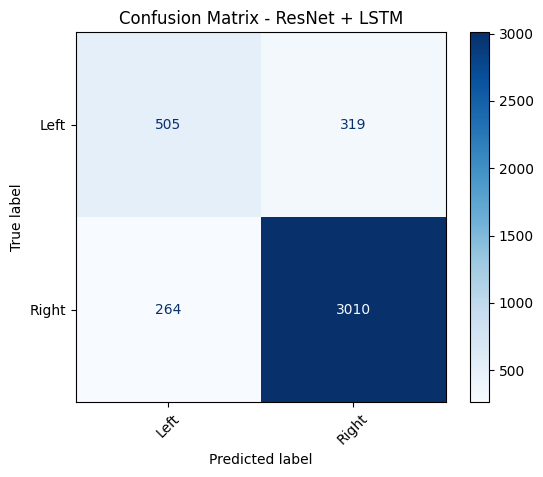

CNN+LSTM: Loss = 0.3984, Accuracy = 0.8131
ResNet: Loss = 0.6195, Accuracy = 0.8141
ResNet+LSTM: Loss = 0.3069, Accuracy = 0.8577


In [1]:
# ALL-IN-ONE: Train and compare CNN, CNN+LSTM, CNN+Transformer, ResNet, ResNet+LSTM, Transformer
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# === LOAD DATA ===
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

num_classes = len(label_encoder.classes_)
input_shape = X_train.shape[1:]

results = {}

def plot_history(history, name):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{name} Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.show()

def plot_confusion(model, name):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    plt.figure(figsize=(10, 8))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f'Confusion Matrix - {name}')
    plt.grid(False)
    plt.show()
"""
# === 1. CNN only ===
cnn = models.Sequential([
    layers.Conv1D(32, 5, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(), layers.MaxPooling1D(), layers.Dropout(0.3),
    layers.Conv1D(64, 5, activation='relu'),
    layers.BatchNormalization(), layers.MaxPooling1D(), layers.Dropout(0.3),
    layers.Flatten(), layers.Dense(64, activation='relu'),
    layers.Dropout(0.5), layers.Dense(num_classes, activation='softmax')
])
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h_cnn = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)
results['CNN'] = cnn.evaluate(X_test, y_test)
plot_history(h_cnn, 'CNN')
plot_confusion(cnn, 'CNN')
"""

# === 2. CNN + LSTM ===
cnn_lstm = models.Sequential([
    layers.Conv1D(32, 5, activation='relu', input_shape=input_shape), layers.BatchNormalization(),
    layers.MaxPooling1D(), layers.Dropout(0.3),
    layers.Conv1D(64, 5, activation='relu'), layers.BatchNormalization(),
    layers.MaxPooling1D(), layers.Dropout(0.3),
    layers.LSTM(64), layers.Dropout(0.4),
    layers.Dense(64, activation='relu'), layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
cnn_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h_lstm = cnn_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32,
                      callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)
results['CNN+LSTM'] = cnn_lstm.evaluate(X_test, y_test)
plot_history(h_lstm, 'CNN + LSTM')
plot_confusion(cnn_lstm, 'CNN + LSTM')

"""
# === 3. CNN + Transformer ===
def transformer_block(x, head_size, num_heads, ff_dim, dropout=0.3):
    x1 = layers.LayerNormalization(epsilon=1e-6)(x)
    x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x1, x1)
    x1 = layers.Dropout(dropout)(x1)
    res = x + x1
    x2 = layers.LayerNormalization(epsilon=1e-6)(res)
    x2 = layers.Dense(ff_dim, activation='relu')(x2)
    x2 = layers.Dropout(dropout)(x2)
    return res + x2

input_tf = Input(shape=input_shape)
x = layers.Conv1D(64, 5, padding='same', activation='relu')(input_tf)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = transformer_block(x, 64, 4, 128)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(num_classes, activation='softmax')(x)
cnn_transformer = models.Model(input_tf, out)
cnn_transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h_tf = cnn_transformer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32,
                           callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)
results['CNN+Transformer'] = cnn_transformer.evaluate(X_test, y_test)
plot_history(h_tf, 'CNN + Transformer')
plot_confusion(cnn_transformer, 'CNN + Transformer')
"""
# === 4. ResNet ===
def residual_block(x, filters, kernel_size=5):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, padding='same')(shortcut)
    x = layers.Add()([x, shortcut])
    return layers.ReLU()(x)

input_r = Input(shape=input_shape)
x = layers.Conv1D(32, 7, padding='same', activation='relu')(input_r)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D()(x)
x = residual_block(x, 64)
x = layers.MaxPooling1D()(x)
x = residual_block(x, 128)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(num_classes, activation='softmax')(x)
resnet = models.Model(input_r, out)
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h_res = resnet.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32,
                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)
results['ResNet'] = resnet.evaluate(X_test, y_test)
plot_history(h_res, 'ResNet')
plot_confusion(resnet, 'ResNet')

# === 5. ResNet + LSTM ===
input_rl = Input(shape=input_shape)
x = layers.Conv1D(32, 7, padding='same', activation='relu')(input_rl)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D()(x)
x = residual_block(x, 64)
x = residual_block(x, 128)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(num_classes, activation='softmax')(x)
resnet_lstm = models.Model(input_rl, out)
resnet_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h_rl = resnet_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)
results['ResNet+LSTM'] = resnet_lstm.evaluate(X_test, y_test)
plot_history(h_rl, 'ResNet + LSTM')
plot_confusion(resnet_lstm, 'ResNet + LSTM')

"""
# === 6. Transformer pur ===
input_tp = Input(shape=input_shape)
x = layers.Dense(64)(input_tp)
x = transformer_block(x, 64, 4, 128)
x = transformer_block(x, 64, 4, 128)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(num_classes, activation='softmax')(x)
transformer = models.Model(input_tp, out)
transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h_tp = transformer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)
results['Transformer pur'] = transformer.evaluate(X_test, y_test)
plot_history(h_tp, 'Transformer pur')
plot_confusion(transformer, 'Transformer pur')
"""
# === Final summary ===
for model_name, (loss, acc) in results.items():
    print(f'{model_name}: Loss = {loss:.4f}, Accuracy = {acc:.4f}')
